# U-NET

This notebook shows how to detect deadwood with U-Net, when the problem is *Semantic segmentation*.

First import, tell where the files are and make dataloaders.

In [ ]:
from fastai.vision.all import *
from pathlib import Path
import sys
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))

from drone_detector.tiling import *
from drone_detector.visualizations import *
from drone_detector.metrics import *
from drone_detector.augmentations import *
from drone_detector.segmentation import *

In [ ]:
fnames = [Path(f'../data/analysis_data/raster_tiles/{f}') for f in 
          os.listdir('../data/analysis_data/rasterized_vector_tiles/')]
   

In [ ]:
item_tfms = segmentation_aug_tfms_fastai(size=160)

deadwood = SegmentationDataLoaders.from_label_func('../data/analysis_data', bs=16,
                                                   fnames=fnames,
                                                   label_func=partial(label_with_matching_fname, path='../data/analysis_data/rasterized_vector_tiles/'),
                                                   item_tfms = [item_tfms],
                                                   batch_tfms= [
                                                       Normalize.from_stats(*imagenet_stats),
                                                   ])

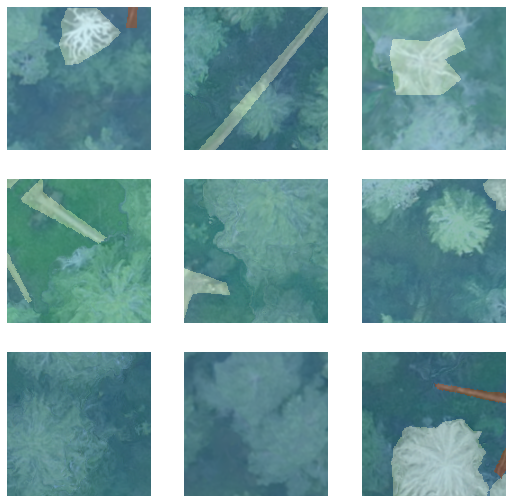

In [ ]:
deadwood.show_batch()

Create a unet_learner with pretrained resnet50 as a backbone.

In [ ]:
learn = unet_learner(deadwood, resnet50, pretrained=True, n_in=3, n_out=3, 
                     metrics=[foreground_acc, DiceMulti()]).to_fp16()

Due to memory issues, use mixed-precision training here.

Fine-tune for 2 freeze-epochs and 20 training epochs.

In [ ]:
learn.fine_tune(20,freeze_epochs=2)

epoch,train_loss,valid_loss,foreground_acc,dice_multi,time
0,2.121042,0.155972,0.087770,0.402029,00:46
1,0.778800,0.158947,0.097346,0.405980,00:26


epoch,train_loss,valid_loss,foreground_acc,dice_multi,time
0,0.149865,0.127615,0.125570,0.443823,00:27
1,0.138114,0.112045,0.270522,0.576563,00:27
2,0.139580,0.119580,0.170337,0.507498,00:27
3,0.139075,0.168210,0.581806,0.633983,00:27
4,0.124490,0.112104,0.109860,0.448093,00:27
5,0.113386,0.084733,0.622238,0.720878,00:26
6,0.102796,0.083020,0.482292,0.721001,00:27
7,0.091127,0.074199,0.743688,0.788099,00:26
8,0.081401,0.074646,0.771972,0.795443,00:27
9,0.076219,0.073481,0.617033,0.769666,00:27


Return to full-precision.

In [ ]:
learn.to_fp32()

See results.

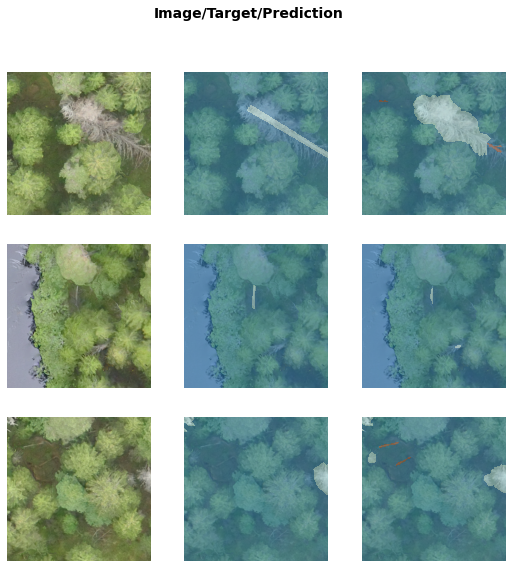

In [ ]:
learn.show_results(max_n=9)

In [ ]:
preds = learn.get_preds(with_input=True, with_decoded=True)

More informative way to see predictions.

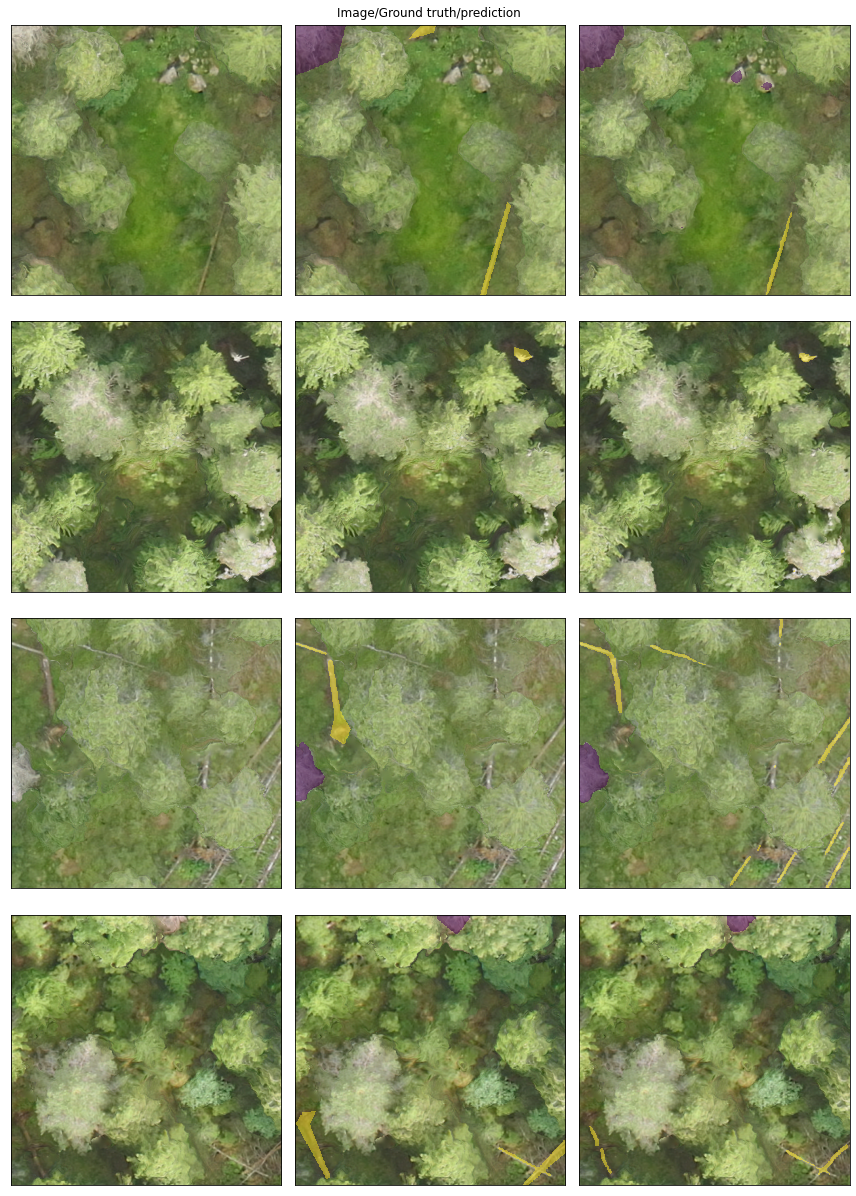

In [ ]:
show_im_mask_pred(preds, max_n=4)

In [ ]:
learn.export('album_unet_export.pkl')

In [ ]:
learn = load_learner('../data/analysis_data/album_unet_export.pkl')